In [9]:
import process 
import pandas as pd
import numpy as np


# Nail path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv'
# Jerome path : 'C:\Users\33640\OneDrive\Documents\GitHub\Portfolio_clustering_project\Data\DATA_Statapp.csv'
# Mohamed path : '/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv'
df = pd.read_csv('/Users/khelifanail/Documents/GitHub/Portfolio_clustering_project/Data/DATA_Statapp.csv')

# Apply conversion function to 'open' and 'close' columns
df['open'] = df['open'].apply(process.safe_literal_eval)
df['close'] = df['close'].apply(process.safe_literal_eval)

# Calculate returns for each line
df['return'] = df.apply(lambda row: [(close - open) / open for open, close in zip(row['open'], row['close'])], axis=1)

new_df = df[['ticker', 'return']] # create a new data frame with the column ticker and return 

# Créons le DataFrame à partir des listes dans 'return'
# On suppose ici que 'new_df' est déjà défini et contient la colonne 'return'

# Convertir chaque liste dans la colonne 'return' en plusieurs colonnes dans le nouveau DataFrame
returns_df = pd.DataFrame(new_df['return'].tolist())

# Ajouter la colonne 'ticker' du 'new_df' au début de 'returns_df'
returns_df.insert(0, 'ticker', new_df['ticker'])

# Renommer les colonnes pour refléter qu'elles sont des rendements
returns_df.columns = ['ticker'] + [f'return_{i}' for i in range(len(returns_df.columns) - 1)]

df_cleaned = process.remove_rows_with_nan(returns_df)
df_cleaned.reset_index(drop=True, inplace=True)

process.check_nan_inf(df_cleaned)

df_cleaned.set_index('ticker', inplace=True) ## ces deux lignes sont fondamentales, ne pas les retirer !!
df.set_index('ticker', inplace=True)

There are no NaN values in the dataframe


In [10]:
import warnings 

warnings.filterwarnings("ignore") ## so that there are no polluting warnings as output of this cell

lookback_window = [4000, 4750]
number_of_clusters = 20
sigma = 2
clustering_method = 'SPONGE' 
number_of_repetition = 20
evaluation_window = 7
PnL = []
overall_return = pd.DataFrame()
portfolio_value=[1] #we start with a value of 1, the list contain : the porfolio value at the start of each evaluation period

for i in range(1, 21):

    consolidated_W = process.consolidated_W(number_of_repetitions=number_of_repetition, lookback_window=lookback_window, df_cleaned=df_cleaned, number_of_clusters=number_of_clusters, sigma=sigma, df=df)

    portfolio_return = process.portfolio_returns(evaluation_window=evaluation_window, df_cleaned=df_cleaned, lookback_window=lookback_window, consolidated_W=consolidated_W)

    overall_return = pd.concat([overall_return, portfolio_return])

    lookback_window = [lookback_window[0] + evaluation_window*i, lookback_window[1] + evaluation_window*i]

    PnL = np.concatenate((PnL, np.reshape(np.cumprod(1 + portfolio_return)*portfolio_value[-1] - portfolio_value[-1], (evaluation_window,))))## car on réinvestit immédiatement après
    portfolio_value.append(portfolio_value[-1]+PnL[-1])
    print('*'*i)
    print(portfolio_value[-1])
        

*
1.0104862196460573
**
1.0067285942814654


OptimizationError: ('Please check your objectives/constraints or use a different solver.', 'Solver status: unbounded')

In [27]:
import plotly.express as px

cumulated_return = overall_return.cumsum()

df = pd.DataFrame(cumulated_return)

# Melt the DataFrame for easier plotting
df_melted = df.reset_index().melt(id_vars='index', var_name='Time Period', value_name='Portfolio Return')

# Plotting with Plotly
fig = px.line(df_melted, x='index', y='Portfolio Return', color='Time Period',
              labels={'index': 'Time Period', 'Portfolio Return': 'Portfolio Return'},
              title='Portfolio Returns Over Time',
              template='plotly_dark')

# Customize x-axis tick labels
fig.update_layout(xaxis=dict(tickmode='array', tickvals=df.index, ticktext=['return_' + str(i) for i in df.index]))

# Show the plot
fig.show()


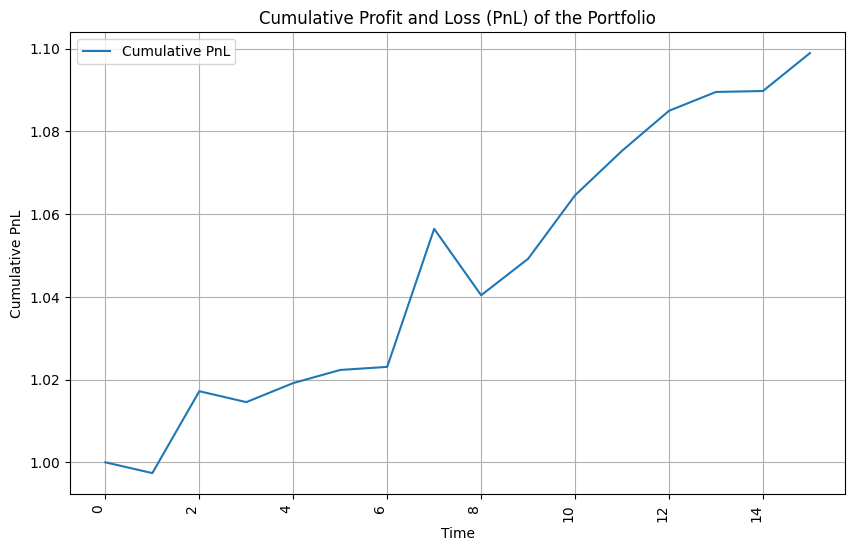

In [14]:
import matplotlib.pyplot as plt 

# Tracé du PnL cumulatif
plt.figure(figsize=(10, 6))
plt.plot(portfolio_value, label='Cumulative PnL')
plt.title('Cumulative Profit and Loss (PnL) of the Portfolio')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)

plt.xticks(rotation=90, ha='right')

plt.show()


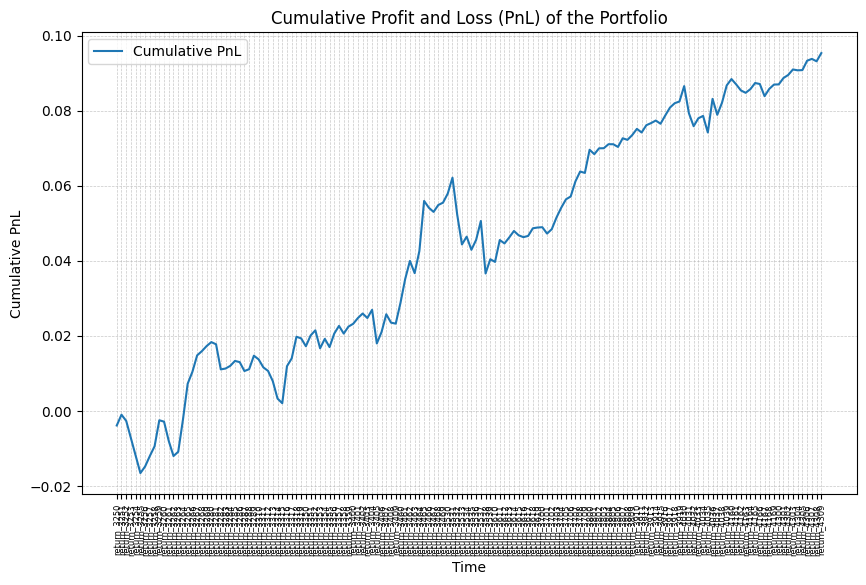

In [21]:
import matplotlib.pyplot as plt 

# Tracé du PnL cumulatif
plt.figure(figsize=(10, 6))
plt.plot(overall_return.cumsum(), label='Cumulative PnL')
plt.title('Cumulative Profit and Loss (PnL) of the Portfolio')
plt.xlabel('Time')
plt.ylabel('Cumulative PnL')
plt.legend()
plt.grid(True)

plt.xticks(rotation=90)
plt.xticks(fontsize=6)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.show()

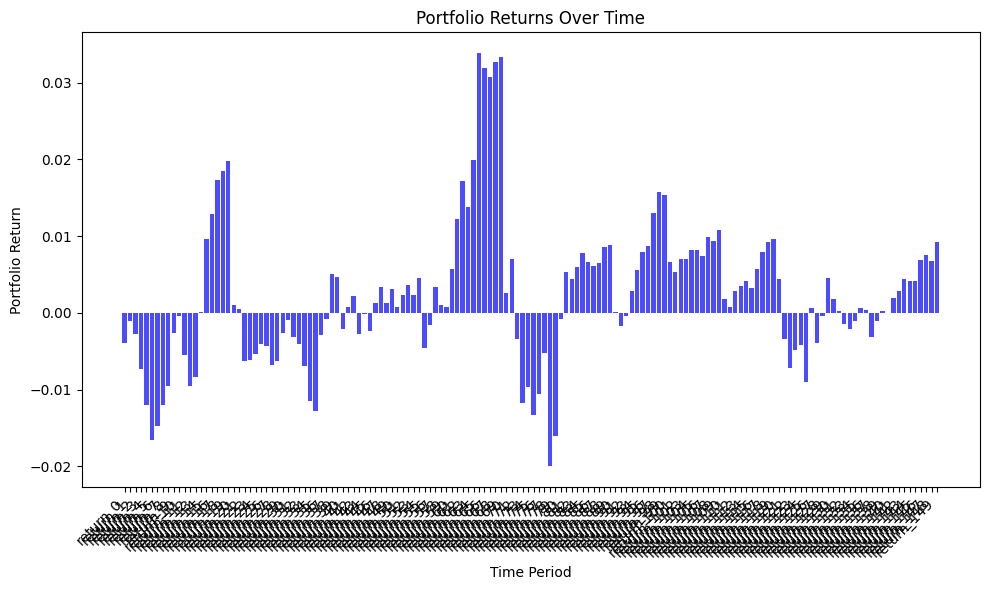

In [32]:
plt.figure(figsize=(10, 6))
plt.bar(range(len(PnL)), PnL, color='blue', alpha=0.7)

# Customize the plot
plt.xlabel('Time Period')
plt.ylabel('Portfolio Return')
plt.title('Portfolio Returns Over Time')
plt.xticks(range(len(PnL)), ['return_{}'.format(i) for i in range(len(PnL))], rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()